# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Tue Nov 21 02:49:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Installs the **current stable version** of RAPIDSAI's core libraries using pip, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. xgboost

**This will complete in about 3-4 minutes**

Please use the [RAPIDS Conda Colab Template notebook](https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9) if you need to install any of RAPIDS Extended libraries, such as:
- cuSpatial
- cuSignal
- cuxFilter
- cuCIM

OR
- nightly versions of any library


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 395 (delta 92), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (395/395), 108.50 KiB | 15.50 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 882.2 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 995.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [3]:
import cudf
cudf.__version__

'23.10.02'

In [4]:
import cuml
cuml.__version__

'23.10.00'

In [5]:
import cugraph
cugraph.__version__

'23.10.00'

In [6]:
import cupy as cp
cp.__version__

'12.2.0'

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm import tqdm
from collections import namedtuple
from cuml.svm import SVR
from cuml.linear_model import Ridge
from cuml.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split
from cuml import metrics

In [9]:
# @title Original function
def pooling(df,spl = 10):
  col = np.arange(int(df.shape[1]/spl))*spl
  pool_val = [];col_ = []
  for i in range(len(col[:-1])):
    pool_val.append(df.values[:, col[i]:col[i+1]].mean(1))
    col_.append(np.mean(df.columns[col[i]:col[i+1]].astype('float64')))
  pool_val.append(df.values[:, col[-1]:].mean(1))
  col_.append(np.mean(df.columns[col[-1]:].astype('float64')))
  return pd.DataFrame(np.array(pool_val).T,columns = col_,index = df.index)

def train_(X,y,model,cv = 10,label = 'aBMD $[g/cm^2]$'):
  res_pred = np.zeros_like(y);r2_add=[]
  cv = KFold(n_splits=cv, shuffle=True, random_state=1234)
  for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    res_pred[test_index] = pred
    print('r2 = ', metrics.r2_score(y_test,pred))
    r2_add.append(metrics.r2_score(y_test,pred))
  print('All r2 = ', metrics.r2_score(y,res_pred))
  print('Mean r2 = ', round(np.mean(r2_add),5),'±', round(np.std(r2_add),5))
  showGraph(y,res_pred,label = label,dpi=100)
  return res_pred, metrics.r2_score(y,res_pred)

def showGraph(y,res_pred,label = 'aBMD $[g/cm^2]$',dpi=100,figsize =(4,4)):
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot(y,res_pred,'.' ,c = 'k')
  correlationLine(y,res_pred,score = 'r2')
  plt.legend(edgecolor='none')
  plt.xlabel('Reference '+label)
  plt.ylabel('Predicted '+label)
  plt.show()
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot((y+res_pred)/2,y-res_pred,'.' ,c = 'k')
  max_ = max((y+res_pred)/2)
  min_ = min((y+res_pred)/2)
  mean_ = np.mean(y-res_pred)
  upp_ = mean_+1.96*np.std(y-res_pred)
  low_ = mean_-1.96*np.std(y-res_pred)
  plt.plot([min_,max_],[mean_,mean_],':',c = 'k')
  plt.plot([min_,max_],[upp_,upp_],'-.',c = 'k')
  plt.plot([min_,max_],[low_,low_],'-.',c = 'k')
  correlationLine((y+res_pred)/2,y-res_pred)
  plt.legend(edgecolor='none')
  label_ = 'Mean of predicted and reference '+label
  plt.xlabel(label_)
  label_ = 'Difference between \n predicted and reference '+label
  plt.ylabel(label_)
  plt.show()
  print('loa_upper: ',round(upp_,5))
  print('loa_lower: ',round(low_,5))
  print("Mean: ",mean_)

def correlationLine(x,y,score = 'r'):
  x = np.array(x).flatten()
  y = np.array(y).flatten()
  #相関
  if score =='r':
    slope, intercept, r_value, _, _ = stats.linregress(x,y)
    r, p = stats.pearsonr(x,y)
    print(stats.spearmanr(x,y))
    label_ = "r = "+str(round(r_value,3))
  if score == 'r2':
    r_value = metrics.r2_score(x,y)
    label_ = "$r^2$ = "+str(round(r_value,3))
    print('pearsonr:',stats.pearsonr(x,y))
  ysub = np.poly1d(np.polyfit(x,y,1))(x)
  xx = [x.min(),x.max()]
  yy = [ysub.min(),ysub.max()]
  if r_value < 0:
    yy = [ysub.max(),ysub.min()]
  plt.plot(xx,yy,"--",color="0.2",label = label_)

In [10]:
version = "ellipse3"
path = f"/content/drive/MyDrive/Tamura/ML/{version}/dataset/"

files = glob.glob(f"{path}opt_result/*.csv")
sim_params = pd.read_csv(f"{path}params.csv", index_col=0)
len(files)

1253

In [11]:
def process(df, window, spl, step):
  df_1 = df.rolling(window, axis=1).mean().dropna(axis=1)
  df_2 = pooling(df_1, spl=spl)
  df_3 = df_2[::step]
  data = np.log(df_3.values + 1).flatten()
  return data

In [33]:
nn = 1211
spl = 25; window = 20; step = 1
#spl=25; window=20; step=3 # 大竹さんのパラメータ
#spl=25; window=20; step=1 # 田村のパラメータ

dataset = pd.DataFrame()
for i in tqdm(range(nn)):
  df = pd.read_csv(files[i], index_col=0).fillna(0)
  data = process(df, window, spl, step)

  filename = files[i].split('/')[-1].split('.')[0]
  target = sim_params[sim_params["filename"]==filename]["aBMD"]
  subset = pd.Series(np.append(data, target), name=filename, index=[f"var{i}" for i in range(data.size)]+["target"])
  dataset = pd.concat([dataset, subset.to_frame().T])
dataset.head()

100%|██████████| 1211/1211 [00:41<00:00, 28.94it/s]


,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var641,var642,var643,var644,var645,var646,var647,var648,var649,target
2023-11-09T06-32-49_it0121,2.013856e-11,2.919720e-10,1.585140e-09,1.671329e-08,1.358413e-07,0.000002,0.000011,0.000007,6.079833e-07,6.735521e-08,...,1.740802e-07,9.020021e-07,0.000005,0.000010,0.000002,2.128867e-07,1.404419e-08,2.493102e-09,1.879965e-10,2.033752
2023-11-09T06-50-33_it0122,0.000000e+00,9.676837e-11,7.835110e-10,7.626650e-09,7.006017e-08,0.000002,0.000013,0.000008,5.640914e-07,3.601242e-08,...,1.083253e-07,8.753926e-07,0.000005,0.000009,0.000001,1.034758e-07,5.890748e-09,1.039515e-09,7.508949e-11,1.630484
2023-11-09T06-43-49_it0079,1.774014e-10,1.507005e-09,3.884235e-09,3.115924e-08,2.744832e-07,0.000003,0.000021,0.000013,1.290501e-06,1.466176e-07,...,3.944303e-07,1.796827e-06,0.000008,0.000017,0.000003,4.089298e-07,3.435852e-08,4.317913e-09,7.578480e-10,1.522655
2023-11-09T07-09-53_it0123,6.673455e-10,4.273296e-09,1.318811e-08,9.399309e-08,6.204387e-07,0.000006,0.000029,0.000018,2.639671e-06,3.434998e-07,...,7.859053e-07,3.181936e-06,0.000013,0.000028,0.000007,9.545874e-07,1.057390e-07,2.207326e-08,3.478335e-09,1.140739
2023-11-09T06-45-34_it0053,5.783174e-11,1.352401e-09,3.651601e-09,5.038266e-08,4.244100e-07,0.000005,0.000033,0.000021,2.156571e-06,1.869608e-07,...,5.388071e-07,2.832018e-06,0.000013,0.000028,0.000005,5.741954e-07,4.412961e-08,4.952460e-09,4.641338e-10,2.314888


In [34]:
features = dataset.drop('target',axis=1).columns
X = dataset[features].values.astype("float32")
X = (X - X.mean(0)) / X.std(0)
y = dataset.target.values.astype("float32")

In [35]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [50]:
# @title Random Forest
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RF",
        RandomForestRegressor(),
      {"n_estimators": [10, 20, 50, 100, 300],
       "max_features": ["log2", "sqrt", 1.0],
       "max_depth": [10, 20, 30, 40, 50],
       })

In [46]:
# @title Gradient Tree Boosting
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("GTB",
        XGBRegressor(tree_method="hist", device="cuda"),
        {"n_estimators": [10, 20, 50, 100, 300],
         "max_depth": [1, 2, 3, 4, 5],
         "eta": [0.001, 0.01, 0.1, 1.0, 10],
         })

In [41]:
# @title Support Vector Machine
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("SVM",
        SVR(),
       {"kernel": ["rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        })

In [36]:
# @title Ridge Regressor
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RR",
        Ridge(),
       {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
        "fit_intercept": [True, False]
        })

In [51]:
grid_search = GridSearchCV(ml.model, ml.params, cv=10, scoring='r2')
grid_search.fit(X_train_val, y_train_val)
print(f"Model: {ml.model}")
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Test score: {grid_search.score(X_test, y_test)}")

Model: RandomForestRegressor()
Best params: {'max_depth': 20, 'max_features': 1.0, 'n_estimators': 300}
Best score: 0.456967443806455
Test score: 0.4897240305001497


In [38]:
result = {}

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


r2 =  0.3584202527999878
r2 =  0.3151552081108093
r2 =  0.37125200033187866
r2 =  0.40537166595458984
r2 =  0.3717038631439209
r2 =  0.37080055475234985
r2 =  0.36404645442962646
r2 =  0.3540620803833008
r2 =  0.3924793004989624
r2 =  0.4139098525047302
All r2 =  0.37599313259124756
Mean r2 =  0.37172 ± 0.02663
pearsonr: PearsonRResult(statistic=0.6710705817607258, pvalue=2.6447065563504664e-159)


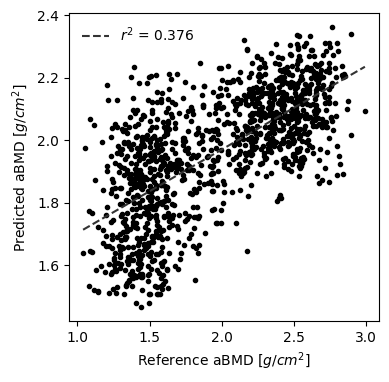

SignificanceResult(statistic=0.8147099748635623, pvalue=2.065281579261863e-288)


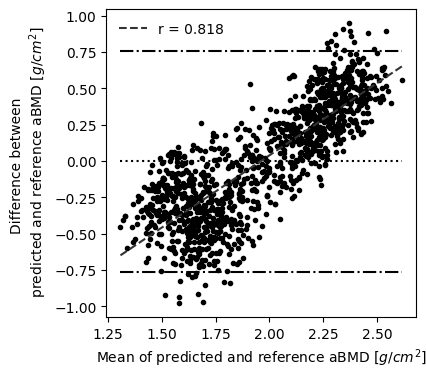

loa_upper:  0.75641
loa_lower:  -0.76047
Mean:  -0.0020339633


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


r2 =  0.49352502822875977
r2 =  0.4417298436164856
r2 =  0.5143874883651733
r2 =  0.5207544565200806
r2 =  0.43100041151046753
r2 =  0.49157631397247314
r2 =  0.4913005828857422
r2 =  0.42040419578552246
r2 =  0.5001596808433533
r2 =  0.4981098771095276
All r2 =  0.48400628566741943
Mean r2 =  0.48029 ± 0.03382
pearsonr: PearsonRResult(statistic=0.7611127103694711, pvalue=1.4960829567576369e-229)


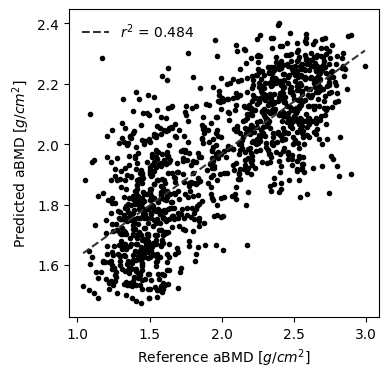

SignificanceResult(statistic=0.8044798616938488, pvalue=8.810362767142647e-276)


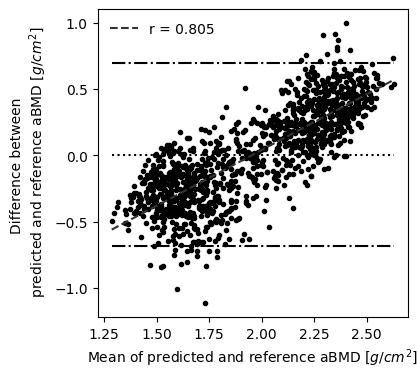

loa_upper:  0.69244
loa_lower:  -0.6869
Mean:  0.0027729135


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


r2 =  0.48804712295532227
r2 =  0.45577549934387207
r2 =  0.488422691822052
r2 =  0.5197471380233765
r2 =  0.43817245960235596
r2 =  0.48393988609313965
r2 =  0.4891340136528015
r2 =  0.41009414196014404
r2 =  0.5124804973602295
r2 =  0.5232384204864502
All r2 =  0.48493707180023193
Mean r2 =  0.48091 ± 0.03457
pearsonr: PearsonRResult(statistic=0.7597111274833722, pvalue=3.1808113270490613e-228)


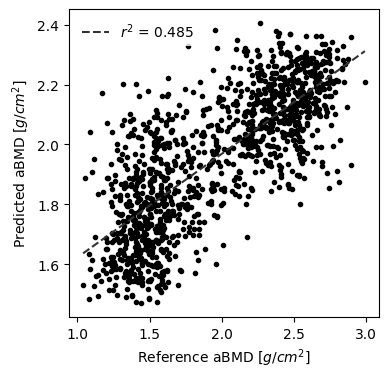

SignificanceResult(statistic=0.8004705725433289, pvalue=4.922091197108945e-271)


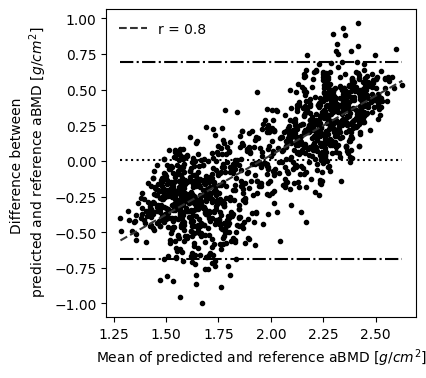

loa_upper:  0.69227
loa_lower:  -0.6858
Mean:  0.0032348586


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


r2 =  0.496393620967865
r2 =  0.4523482322692871
r2 =  0.49160003662109375
r2 =  0.5220743417739868
r2 =  0.4344334006309509
r2 =  0.49360156059265137
r2 =  0.5002446174621582
r2 =  0.4067869782447815
r2 =  0.5225793719291687
r2 =  0.512763500213623
All r2 =  0.4872922897338867
Mean r2 =  0.48328 ± 0.03708
pearsonr: PearsonRResult(statistic=0.7603284855269281, pvalue=8.296640757842788e-229)


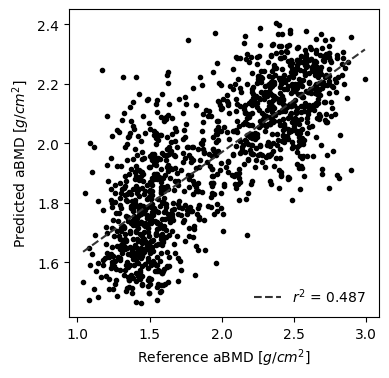

SignificanceResult(statistic=0.7999366876106572, pvalue=2.0706251791091897e-270)


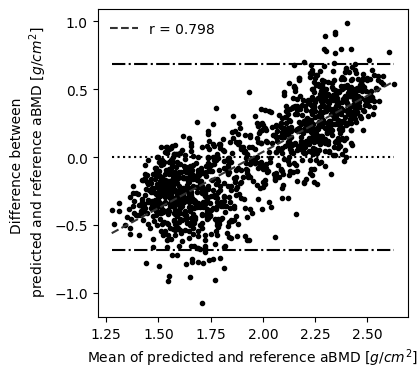

loa_upper:  0.68969
loa_lower:  -0.68527
Mean:  0.0022112883


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


r2 =  0.4958581328392029
r2 =  0.44880080223083496
r2 =  0.4989970922470093
r2 =  0.5218878984451294
r2 =  0.440542995929718
r2 =  0.490106999874115
r2 =  0.4994462728500366
r2 =  0.41595458984375
r2 =  0.5153592228889465
r2 =  0.516128420829773
All r2 =  0.48821842670440674
Mean r2 =  0.48431 ± 0.03442
pearsonr: PearsonRResult(statistic=0.7613139543209979, pvalue=9.629061761173601e-230)


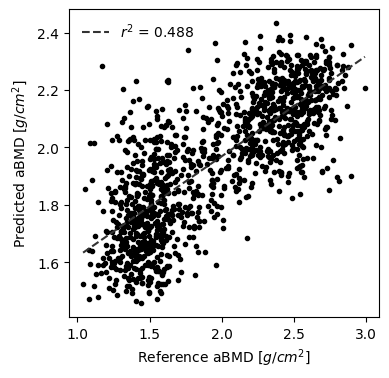

SignificanceResult(statistic=0.8004855391326984, pvalue=4.7274922062373946e-271)


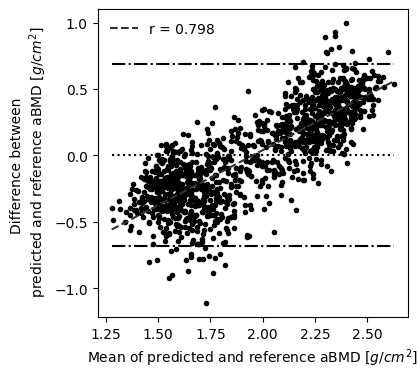

loa_upper:  0.68957
loa_lower:  -0.68412
Mean:  0.0027249795


In [52]:
sub_result = []
sigma = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
ml.model.set_params(**grid_search.best_params_)
for scale in sigma:
  noise = np.random.normal(scale=scale, size=dataset.drop('target', axis=1).shape)
  pred_, r2 = train_(X + noise, y, ml.model, cv=10, label="aBMD $[g/cm^2]$")
  sub_result.append(r2)
result[ml.name] = sub_result

In [53]:
df = pd.DataFrame(result, index=sigma)
df

,RR,SVM,GTB,RF
0.10000,0.317118,0.673622,0.524975,0.375993
0.01000,0.374459,0.779242,0.618674,0.484006
0.00100,0.381177,0.781988,0.613155,0.484937
0.00010,0.381311,0.782189,0.622207,0.487292
0.00001,0.381293,0.782221,0.615729,0.488218


In [54]:
path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"

f_num = len(glob.glob(f"{path}*.csv"))
df.to_csv(f"{path}result{f_num + 1}.csv")